### Setup

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune

import matplotlib.pyplot as plt

In [4]:
config.data_dir

PosixPath('/home/leon_ivan/data')

In [5]:
config.spectra_dir

PosixPath('/home/leon_ivan/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

Load Data

In [6]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=580
)
delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

foreground_mask = (loader.label_map != 4) # disgard background
labeled_mask = (loader.label_map != 0)
delta_A_gt_flat = delta_A_gt_img[:, foreground_mask]
A_gt_flat = A_gt_img[:, foreground_mask]

/home/leon_ivan/miniconda3/envs/idp_leon/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Plot absolute attenuation spectrum at reference_pixel

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


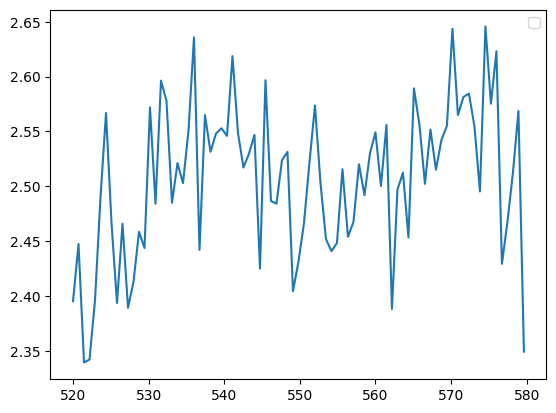

In [7]:
plot_spectrum(A_gt_img[:, loader.reference_pixel[0], loader.reference_pixel[1]], loader.wavelengths)

Load attenuation spectra
Keep in mind, that spectra for water and fat are given for pure solutions, in units of $cm^{-1}$. The "concentrations" for these molecules have to be given as percentages.

In [8]:
mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

Plot molecule attenuation spectra

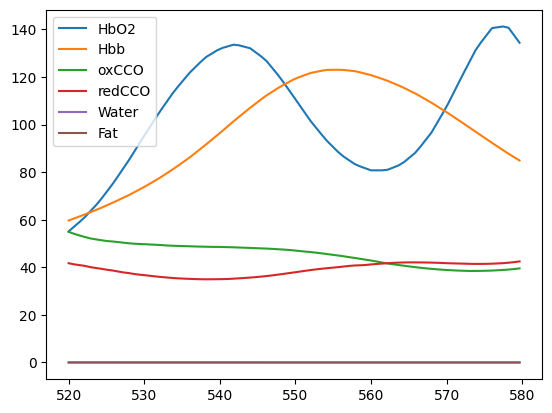

In [9]:
plot_spectra(mu_a_matrix.T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

Plot total attenuation coefficient and scattering for gray matter...

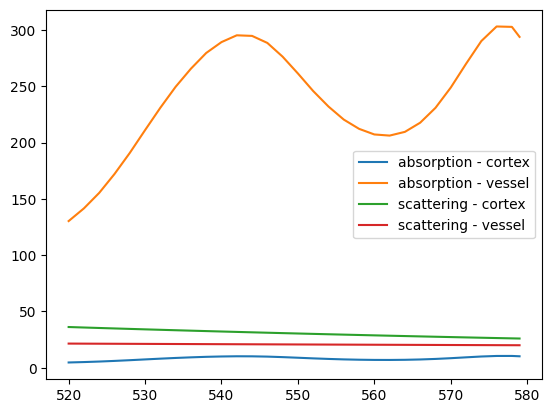

In [16]:
sample_wavelengths = np.arange(520, 580)
plot_spectra(
    (
        loader.mu_a_func_gray_matter(sample_wavelengths),
        loader.mu_a_func_blood_vessel(sample_wavelengths),
        loader.mu_s_red_func_gray_matter(sample_wavelengths),
        loader.mu_s_red_func_blood_vessel(sample_wavelengths)
    ),
    sample_wavelengths,
    ["absorption - cortex", "absorption - vessel", "scattering - cortex", "scattering - vessel"]
)

### Fit MBLL with Pathlengths (for comparison)

Load pathlenghts and interpolate them to used wavelengths

In [18]:
blood_vessel_mcs_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")
gray_matter_mcs_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")

blood_vessel_pl = np.interp(
    loader.wavelengths,
    blood_vessel_mcs_data[:, 0],
    blood_vessel_mcs_data[:, -1]
)

gray_matter_pl = np.interp(
    loader.wavelengths,
    gray_matter_mcs_data[:, 0],
    gray_matter_mcs_data[:, -1]
)

Compute total pathlength that will be used with MBLL, by dividing attenuation by mu_a

In [20]:
blood_vessel_pl_total = -np.log(blood_vessel_mcs_data[:, 3]) / blood_vessel_mcs_data[:, 1]

gray_matter_pl_total = -np.log(gray_matter_mcs_data[:, 3]) / gray_matter_mcs_data[:, 1]


Plot pathlengths

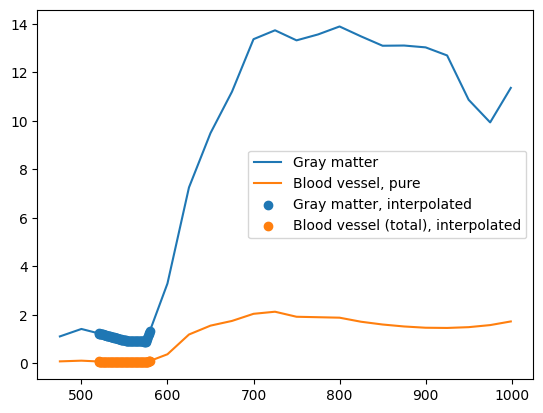

In [21]:
plt.clf()
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_mcs_data[:, -1], label="Gray matter")
plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -1], label="Blood vessel, pure")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -2], label="Blood vessel tissue, vessel layer")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -3], label="Blood vessel tissue, gray matter layer")
#plt.plot(blood_vessel_mcs_data[:, 0], blood_vessel_mcs_data[:, -1], label="Blood vessel, both layers")
plt.scatter(loader.wavelengths, gray_matter_pl, label="Gray matter, interpolated")
plt.scatter(loader.wavelengths, blood_vessel_pl, label="Blood vessel (total), interpolated")
plt.legend()
plt.show()

Build pathlength map

In [22]:
pl_img = np.empty_like(delta_A_gt_img)
pl_img[:, (loader.label_map <= 2)] = gray_matter_pl[:, None]
pl_img[:, (loader.label_map == 3)] = blood_vessel_pl[:, None]
pl_flat = pl_img[:, foreground_mask]
pl_flat /= 10 # convert to cm

#### Fit the MBLL model for attenuation change

In [14]:
delta_c_mbll_flat = concentr_fit_mbll(
    delta_A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    pl_flat
)

delta_c_mbll_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
delta_c_mbll_img[:, foreground_mask] = delta_c_mbll_flat

Plot concentrations

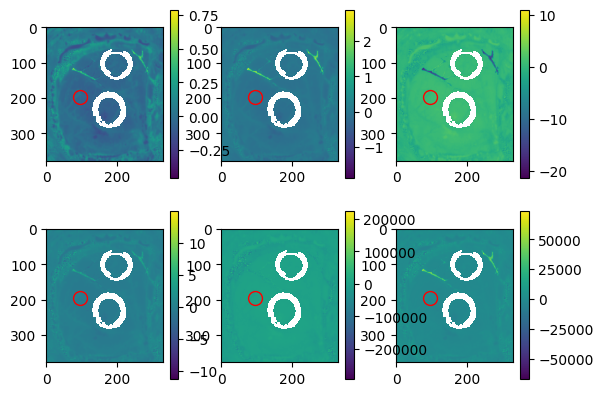

In [15]:
plot_concentration_imgs(delta_c_mbll_img, loader.reference_pixel)

Reconstruct spectra and compare to ground truth

In [16]:
delta_A_reconstr_mbll_flat = mbll_new(loader.wavelengths, mu_a_matrix, delta_c_mbll_flat, pl_flat)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


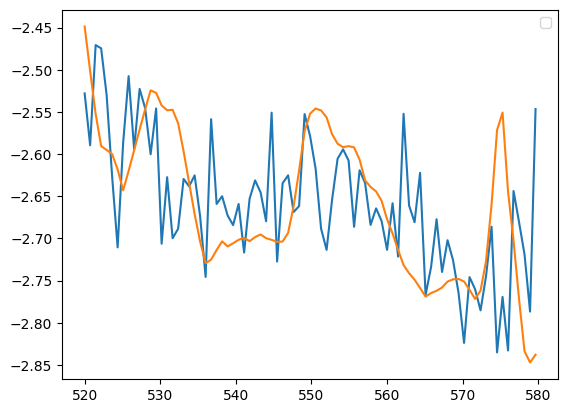

In [17]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((delta_A_gt_flat[:, idx], delta_A_reconstr_mbll_flat[:, idx]), loader.wavelengths)
plt.show()

#### Fit the MBLL model for absolute attenuation

In [18]:
c_mbll_flat = concentr_fit_mbll(
    A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    pl_flat
)
c_mbll_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_mbll_img[:, foreground_mask] = c_mbll_flat

Plot concentration images

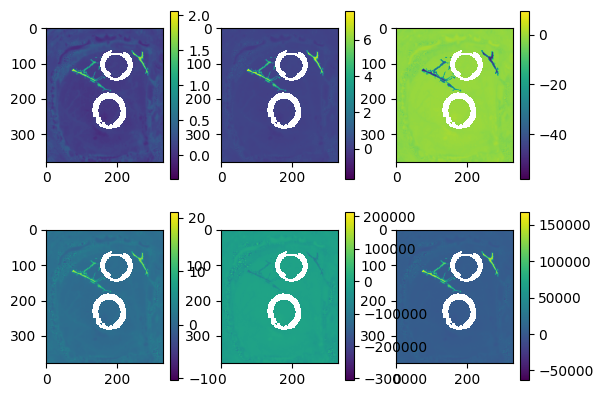

In [19]:
plot_concentration_imgs(c_mbll_img)

### Fit Jacques Model

Load the m-parameters...

In [23]:
with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

Compare the Pathlength computed by Jacques to the Pathlengths from MCS...

In [30]:
g = 0.85
sample_wavelengths = gray_matter_mcs_data[:, 0]
mu_a_pl_compare = data_loader.DataLoader.mu_a_func_gray_matter(sample_wavelengths) / 10
mu_s_red_pl_compare = data_loader.DataLoader.mu_s_red_func_gray_matter(sample_wavelengths) / 10

In [31]:
m1, m2, m3 = m_params[1.36]
delta = 1 / np.sqrt(3 * mu_a_pl_compare * (mu_a_pl_compare + mu_s_red_pl_compare))
A = (m1 + m2 * np.exp(np.log(mu_s_red_pl_compare / mu_a_pl_compare)/m3))
pl_compare = A * delta 

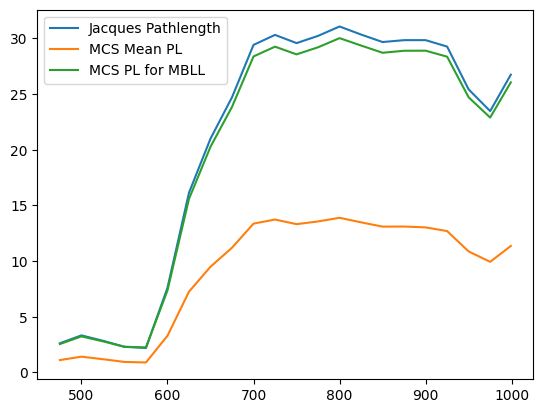

In [33]:
plt.plot(gray_matter_mcs_data[:, 0], pl_compare, label="Jacques Pathlength")
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_mcs_data[:, -1], label="MCS Mean PL")
plt.plot(gray_matter_mcs_data[:, 0], gray_matter_pl_total, label="MCS PL for MBLL")
plt.legend()
plt.show()


In [34]:
pl_compare / gray_matter_mcs_data[:, -1]

array([2.35767468, 2.34719632, 2.38911686, 2.4328363 , 2.45388776,
       2.30673972, 2.22467692, 2.2114711 , 2.20587475, 2.20066949,
       2.20743507, 2.22076804, 2.22866814, 2.23680997, 2.25093751,
       2.26578036, 2.27716785, 2.29051489, 2.30505499, 2.33896179,
       2.36241865, 2.35421828])

Fitting the concentrations for every pixel in the image during hyperparameter search is infeasible, since optimization for one image (i.e. one hyperparameter combination) already takes about 20min. Instead we select all labeled, and a few random unlabeled pixels. Additionally, we make use of the ASHA scheduler, which terminates badly performing trials early.

In [25]:
# every labeled pixel without background
hyperparameter_search_mask = labeled_mask & foreground_mask
# 500 random unlabeled pixels
hyperparameter_search_mask[np.unravel_index(np.random.choice(np.flatnonzero(~labeled_mask), size=1000), labeled_mask.shape)] = True

Plot the mask...

In [26]:

# plotting an rgb image with mask doesn't work for some reason
# hyperparameter_search_img = np.ma.masked_where(np.repeat(~hyperparameter_search_mask[..., None], 3, 2), loader.img)

# convert to grayscale
hyperparameter_search_img = np.dot(loader.img[..., :3], [0.2989, 0.5870, 0.1140])
hyperparameter_search_img[~hyperparameter_search_mask] = np.nan

plt.imshow(hyperparameter_search_img)

#### Fit the Jacques model on attenuation change

In contrast to the MBLL, when using the Jacques model for attenuation change, concentrations are not substracted to form concentration changes. Instead we have to provide absolute concentrations for the reference pixel and the pixel where concentrations are sought. Here, the reference pixel is a pixel of the gray matter area, and its concentrations are treated as hyperparameters. Concentrations of the pixel of interest are optimized using non-linear least-squares.\
For simplicity I assume an average refractive index of 1.38 and use the corresponding values for $m_i$.

In [27]:
c_ref_gray_matter_fractions = loader.params_ref_gray_matter_fraction[:-2]

param_space = [
    # f_blood
    tune.sample_from(lambda _: min(1, max(0, np.random.normal(c_ref_gray_matter_fractions[0], 0.1)))),
    # st02
    tune.sample_from(lambda _: min(1, max(0, np.random.normal(c_ref_gray_matter_fractions[1], 0.25)))),
    # c_oxCCO
    tune.sample_from(lambda _: max(0, np.random.normal(c_ref_gray_matter_fractions[2], 0.001))),
    # c_redCCO
    tune.sample_from(lambda _: max(0, np.random.normal(c_ref_gray_matter_fractions[3], 0.001))),
    # f_water
    tune.sample_from(lambda config: min(1 - config["0"], max(0, np.random.normal(c_ref_gray_matter_fractions[4], 0.2)))),
    # f_fat
    tune.sample_from(lambda config: min(1 - config["0"] - config["4"], max(0, np.random.normal(c_ref_gray_matter_fractions[5], 0.2)))),
    # a
    tune.sample_from(lambda _: max(3, np.random.normal(loader.params_ref_gray_matter[-2], 10))),
    # b
    tune.sample_from(lambda _: max(0.1, np.random.normal(loader.params_ref_gray_matter[-1], 1))),
    # m1
    m_params[1.38][0],
    # m2
    m_params[1.38][1],
    # m3
    m_params[1.38][2]
]

In [28]:
score, config = None, None

In [29]:
# general function that fits a model to data within hyperparameter search
res_grid = concentr_fit_nonlinear_hyperparam_search(
    delta_A_gt_img[:, hyperparameter_search_mask],
    loader.wavelengths,
    mu_a_matrix,
    # the function that is fitted to data
    A_jacques_blood_fraction,
    # parameter space
    param_space=param_space,
    # boolean array indicating which parameters are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=True, # specify that input data is attenuation change
    # how many spectra are optimized before their average error is reported to ray tune
    # high value -> less overhead due to less reports, but unpromising trials will be killed later
    spectra_per_report=25,
    # how many spectra are checked before trial can be killed
    # will be rounded up to multiple of spectra_per_report
    grace_spectra=50,
    num_samples=500,
    time_budget_s=600
)

KeyboardInterrupt: 

In [30]:
score, config = get_best_values_from_res_grid(res_grid)
print(score)
print(config)

NameError: name 'res_grid' is not defined

Compare to previous config, use and store better ones...

In [32]:
score, config = compare_and_update_config(
    score,
    config,
    config.result_dir / "jacques_attenuation_change_hyperparams.pickle",
    overwrite_regardless = False
)

RuntimeError: Current and previous scores are None.

In [35]:
result_path = config.result_dir / f"jacques_attenuation_change/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [36]:
with open(result_path, "rb") as f:
    params_jacques_delta_A_flat = pickle.load(f)

Run the optimization for the entire image, with the best hyperparameters.

In [57]:
# general function that fits a model to data
params_jacques_delta_A_flat, errors = concentr_fit_nonlinear(
    delta_A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction, # the function that is fitted to data
    # reference values for all variables (concentrations first, then other parameters)
    # f_blood, st02, c_oxCCO, c_redCCO, f_water, f_fat, a (scattering), b (scattering), m1, m2, m3
    ref_vals=config,
    # boolean array indicating which variables are constant (False) or optimized (True) per pixel
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10, None, None, None]),
    is_delta_A=True, # specify that input data is attenuation change
)

Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.


KeyboardInterrupt: 

Store new results...

In [34]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_delta_A_flat, f)

NameError: name 'result_path' is not defined

In [42]:
# values are already blood fractions
c_jacques_delta_A_flat = blood_fraction_to_concentrations(params_jacques_delta_A_flat[:6])
c_jacques_delta_A_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_delta_A_img[:, foreground_mask] = c_jaques_delta_A_flat[:6, :] # - config[:6, None]

In [38]:
plot_concentration_imgs(c_jacques_delta_A_img, loader.reference_pixel)

Compare reconstructed spectra (change) to ground truth spectra.

In [43]:
delta_A_reconstr_jacques = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_delta_A_flat,
    params_jacques_delta_A_flat[6, :],
    params_jacques_delta_A_flat[7, :],
    *m_params[1.38]
) - A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    config[:6, None],
    *config[6:]
)

TypeError: 'NoneType' object is not subscriptable

In [130]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((delta_A_gt_flat[:, idx], delta_A_reconstr_jacques[:, idx]), loader.wavelengths)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#### Fit Jacques on Absolute Attenuation

Here, we fit the Jacques model directly against absolute attenuation spectra. The reference values will only serve as an initialization for non-linear least squares for the first pixel. Therefore it should be reasonable to use reference values for gray matter. Subsequent pixels will be initialized with the result of their preceeding pixel.

In [44]:
result_path = config.result_dir / f"jacques_attenuation_absolute/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [46]:
with open(result_path, "rb") as f:
    params_jacques_flat = pickle.load(f)

In [45]:
params_jacques_flat, errors = concentr_fit_nonlinear(
    A_gt_flat,
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_gray_matter_fraction, m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    progress_bar=True
)

Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.


KeyboardInterrupt: 

Store new results...

In [18]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_flat, f)

In [48]:
c_jacques_flat = blood_fraction_to_concentrations(params_jacques_flat[:6, :])
c_jacques_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_img[:, foreground_mask] = params_jacques_flat[:6, :]

In [49]:
plot_concentration_imgs(c_jacques_img)

#### Fit Jacques on Absolute Attenuation, constrain volume fractions

Up until now, we only bounded the individual volume fraction of a molecule to be within $[0, 1]$, and the molar concentrations to be greater than 0. We can also add the constraint, that the sum of volume fractions is within $[0, 1]$. In this case, we can no longer optimize using a non-linear least squares solver like Levenberg Marquardt. As a result the optimization takes about 60x as long as without constraints.

In [50]:
result_path = config.result_dir / f"jacques_attenuation_absolute_constrained/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [51]:
with open(result_path, "rb") as f:
    params_jacques_constrained_flat = pickle.load(f)

In [52]:
params_jacques_constrained_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, foreground_mask & labeled_mask],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((c_ref_gray_matter_fractions, [40.8, 3.089], m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.4, 0.4, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    # linear constraint given as (A (matrix), lb (vector), ub (vector))
    # parameter vector x should satisfy
    # lb <= A @ x <= ub
    constraint=(np.array([[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]]), np.array([0]), np.array([1])),
    progress_bar=True
)

Note: Bounds for parameters 8, 9, 10 will be ignored, as they are not optimized.


KeyboardInterrupt: 

Store new results...

In [28]:
with open(result_path, "wb") as f:
    pickle.dump(params_jacques_flat, f)

In [55]:
c_jacques_constrained_flat = blood_fraction_to_concentrations(params_jacques_constrained_flat[:6, :])
c_jacques_constrained_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_constrained_img[:, foreground_mask & labeled_mask] = c_jacques_constrained_flat

In [56]:
plot_concentration_imgs(c_jacques_constrained_img)

#### Fit Jacques on Absolute Attenuation spectra, with constant scattering, for blood region seprately

Here we again fit the Jacques model to absolute attenuation spectra but assume constant scattering in blood vessel, and non-blood vessel areas. Here we can also take different $m_i$'s into account.

In [57]:
result_path = config.result_dir / f"jacques_attenuation_absolute_const_scatter/{loader.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [62]:
with open(result_path, "rb") as f:
    c_jacques_blood_vessel_flat, c_jacques_gray_matter_flat = pickle.load(f)

In [59]:
c_jacques_blood_vessel_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, (loader.label_map == 3)],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_blood_vessel_fraction, m_params[1.4])),
    variables_bool_arr=np.array([True, True, True, True, True, True, False, False, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 0.5, 0.01, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None])
)

Note: Bounds for parameters 6, 7, 8, 9, 10 will be ignored, as they are not optimized.


KeyboardInterrupt: 

In [60]:
c_jacques_gray_matter_flat, errors = concentr_fit_nonlinear(
    A_gt_img[:, (loader.label_map <= 2)],
    loader.wavelengths,
    mu_a_matrix,
    A_jacques_blood_fraction,
    ref_vals=np.concatenate((loader.params_ref_gray_matter_fraction, m_params[1.38])),
    variables_bool_arr=np.array([True, True, True, True, True, True, False, False, False, False, False]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1, None, None, None]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10, None, None, None]),
    is_delta_A=False,
    progress_bar=True
)

Note: Bounds for parameters 6, 7, 8, 9, 10 will be ignored, as they are not optimized.


KeyboardInterrupt: 

Store new results...

In [55]:
with open(result_path, "wb") as f:
    pickle.dump((c_jacques_blood_vessel_flat, c_jacques_gray_matter_flat), f)

In [64]:
c_jacques_blood_vessel_flat = blood_fraction_to_concentrations(c_jacques_blood_vessel_flat)
c_jacques_gray_matter_flat = blood_fraction_to_concentrations(c_jacques_gray_matter_flat)
c_jacques_const_scatter_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_jacques_const_scatter_img[:, (loader.label_map == 3)] = c_jacques_blood_vessel_flat
c_jacques_const_scatter_img[:, (loader.label_map <= 2)] = c_jacques_gray_matter_flat

In [65]:
plot_concentration_imgs(c_jacques_const_scatter_img)

We can also see how the (absolute) ground truth spectra compare to the reconstructed spectra.

In [62]:
A_reconstr_jacques_const_scatter_img = np.empty_like(A_gt_img)
A_reconstr_jacques_const_scatter_img[:, (loader.label_map == 3)] = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_blood_vessel_flat,
    22.0,
    0.660,
    *m_params[1.4]
)
A_reconstr_jacques_const_scatter_img[:, (loader.label_map <= 2)] = A_jacques_new(
    loader.wavelengths,
    mu_a_matrix,
    c_jacques_gray_matter_flat,
    40.8,
    3.089,
    *m_params[1.4]
)
A_reconstr_jacques_const_scatter_flat = A_reconstr_jacques_const_scatter_img[:, foreground_mask]

In [65]:
idx = np.random.randint(0, A_gt_flat.shape[1])
plot_spectra((A_gt_flat[:, idx], A_reconstr_jacques_const_scatter_flat[:, idx]), loader.wavelengths)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Fit the model from Monte Carlo Simulations

In [36]:
mcs_obj = SimulationAttenuation(config.mcs_func_path)

In [38]:
loader_mcs = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=10
)
delta_A_gt_mcs_img = loader_mcs.get_attenuation_change("020-01")
A_gt_mcs_img = loader_mcs.get_attenuation("020-01")

mu_a_matrix_mcs = loader_mcs.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [39]:
loader_mcs.wavelengths

array([520.        , 556.36363636, 592.72727273, 629.81818182,
       666.18181818, 702.54545455, 738.90909091, 776.        ,
       812.36363636, 848.72727273])

In [69]:
A_gt_mcs_img[:, foreground_mask & labeled_mask].shape

(10, 7010)

### Fit the MC model on absolute attenuation

In [70]:
result_path = config.result_dir / f"mcs_attenuation_absolute/{loader_mcs.patient_id}"
os.makedirs(result_path.parent, exist_ok=True)

Load previous results...

In [71]:
with open(result_path, "rb") as f:
    params_mcs_flat = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/media/leon/T7/IDP/results/mcs_attenuation_absolute/020-01'

In [72]:
params_mcs_flat, errors = concentr_fit_nonlinear(
    A_gt_mcs_img[:, foreground_mask & labeled_mask],
    loader_mcs.wavelengths,
    mu_a_matrix_mcs,
    mcs_obj.A_blood_fraction,
    jacobian=mcs_obj.jacobian_blood_fraction,
    ref_vals=blood_fraction_to_concentrations(loader_mcs.params_ref_gray_matter),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.04, 0.04, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=True
)

/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:74: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_upper = np.sum(np.nan_to_num(weights_upper * self.photon_data[mu_s_upper_idxs, 0, :]), axis=-1) / total_weights_upper
/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/src/mcs_function.py:75: RuntimeWarning: invalid value encountered in multiply
  weighted_pl_lower = np.sum(np.nan_to_num(weights_lower * self.photon_data[mu_s_upper_idxs - 1, 0, :]), axis=-1) / total_weights_lower


KeyboardInterrupt: 

Store new results...

In [ ]:
with open(result_path, "wb") as f:
    pickle.dump(params_mcs_flat, f)

In [ ]:
c_mcs_flat = blood_fraction_to_concentrations(params_mcs_flat[:6, :])
c_mcs_img = np.full((6, *A_gt_img.shape[1:]), np.NaN)
c_mcs_img[:, foreground_mask & labeled_mask] = c_mcs_flat[:6, :]

In [ ]:
plot_concentration_imgs(c_mcs_img)